# Adaptive PDE discretizations on Cartesian grids
## Volume : Non-divergence form PDEs
## Part : Monotone numerical schemes
## Chapter : PDEs with a first order non-linearity

This notebook illustrates the use of monotone finite difference schemes to compute viscosity solutions of non-linear PDEs, in two space dimensions. 
We consider the PDE
$$
    {-} \mathrm{Tr}(A(x) \nabla^2 u(x)) + F(x, \nabla u(x)) = 1,
$$
with Dirichlet boundary conditions, where $\|v\|_D^2 := <v,D v>$. 
For illustration, we consider a quadratic non-linearity:
$$
    F(x, \nabla u(x)) := \| \nabla u(x) -\omega(x)\|^2_{D(x)}
$$
More details on this problem below.


Two possibilities are considered for the discretization of the first order non-linear (quadratic) term, in a monotone fashion. One is second order accurate, but requires the diffusion tensors $A$ to be positive definite, and the solution to be smooth enough, for monotony to hold. The other possibility is only first order accurate, but unconditionally monotone.

Our numerical schemes use adaptive stencils, and depend on Selling's decomposition of the diffusion tensors $A$ and $D$. Their implementation is fairly simple and compact (approx. ten lines) thanks to the use of sparse automatic differentiation.

**Reference.**

The use of Selling's algorithm for the discretization of anisotropic PDEs was first introduced in:
* Bonnans, J. F., Ottenwaelter, E., Zidani, H. (2004). A fast algorithm for the two dimensional HJB equation of stochastic control. ESAIM: Mathematical Modelling and Numerical Analysis, 38(4), 723–735.
* Fehrenbach, J., & Mirebeau, J.-M. (2014). Sparse non-negative stencils for anisotropic diffusion. Journal of Mathematical Imaging and Vision, 49(1), 123–147. http://doi.org/http://dx.doi.org/10.1007/s10851-013-0446-3

[**Summary**](Summary.ipynb) of volume Non-Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. Numerical schemes](#1.-Numerical-schemes)
    * [1.1 Centered scheme](#1.1-Centered-scheme)
    * [1.2 Upwind type scheme](#1.2-Upwind-type-scheme)
    * [1.3 Numerical tests](#1.3-Numerical-tests)
    * [1.4 Alternative centered scheme](#1.4-Alternative-centered-scheme)
  * [2. Pure eikonal equations](#2.-Pure-eikonal-equations)
    * [2.1 A Riemannian eikonal equation](#2.1-A-Riemannian-eikonal-equation)
    * [2.2 An eikonal equation of Rander type](#2.2-An-eikonal-equation-of-Rander-type)



**Acknowledgement.** Some of the experiments presented in these notebooks are part of 
ongoing research with Ludovic Métivier and Da Chen.

Copyright Jean-Marie Mirebeau, Centre Borelli, ENS Paris-Saclay, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [1]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('NonlinearMonotoneFirst2D','NonDiv'))

In [2]:
from agd import Selling
from agd import LinearParallel as lp
from agd import AutomaticDifferentiation as ad
from agd import Domain

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg;
import itertools

Some utility functions

In [4]:
newton_root = ad.Optimization.newton_root
stop = ad.Optimization.stop_default
every4 = itertools.count(1,4)

## 1. Numerical schemes

We propose several approches for discretizing the proposed PDE, whose properties are summarized below:

| Finite differences | Monotony | Accuracy | Non-linearity |
|--|--|--|--|
| Centered | Conditional | Second order | General |
| Upwind  | Unconditional | First order | Quadratic |

<!---| Alternative centered | Conditional | Second order | Quadratic specific |
--->

### 1.1 Centered scheme 

Recall that we consider the PDE 
$$
-\mathrm{Tr}(A(x) \nabla^2 u(x)) + F(x, \nabla u(x)) = 1
$$
with Dirichlet boundary conditions. 

We propose below a numerical scheme, that is degenerate elliptic (maximum principle holds) under the following additional assumptions:
* the tensors $A(x)$ are Lipschitz and uniformly positive definite,
* the function $F$ uniformly Lipschitz in its second variable, 
* the discretization grid scale $h>0$ is sufficiently small.

The discretization of the first order term $F(x,\nabla u(x))$ is based on centered finite differences, along specific directions. Their lack of monotony is compensated by the second order term $-\mathrm{Tr}(A(x) \nabla^2 u(x))$. 

**Connection with the Lax-Friedrichs approximation.**
The Lax Friedrichs approximation is based, likewise, on the use of centered finite differences, whose monotony is compensated by a linear second order operator. The key difference is, however, that the Lax-Friedrichs scheme only uses finite differences along the coordinate axes, and introduces an additional isotropic diffusion term, thus loosing second order accuracy.

<!---
Note : the usual Lax-Friedrichs approximation is obtained in the special case where $A = h \mathrm{Id}$.
--->

**Note on the uniform Lipschitz regularity assumption.**
The non-linearity $F$ considered in our examples is quadratic, hence it isn't uniformly Lipschitz. 
As a result, the scheme looses the degenerate ellipticity property if the solution gradient is excessively large, or unbounded.

**Discretization of the second order term.** Consider a tensor decomposition of the form
$$
    A(x) = \sum_{1 \leq i \leq n} \mu_i(x) e_i(x) e_i(x)^T,
$$
where $\mu_i(x)\geq 0$ and $e_i(x)$ has integer entries. Typically, we obtain such a decomposition using Selling's formula. The second order part of the operator is discretized using centered finite differences.
$$
    -\mathrm{Tr}(A(x) \nabla^2 u(x)) = -\sum_{1 \leq i \leq n} \mu_i(x) \frac{u(x+he_i(x)) - 2 u(x) +u(x-h e_i(x))}{h^2} + O(h^2).
$$


**Discretization of the first order term.**
We approximate the product $A(x)\nabla u(x)$ using second order finite differences:
$$
A(x) \nabla u(x) = \sum_{1 \leq i \leq n} \mu_i \frac{u(x+h e_i)-u(x-h e_i)} {2 h} e_i + O(h^2).
$$
Form this point, a second order finite difference approximation of the gradient $\nabla u(x)$ is obtained by applying the linear mapping $A(x)^{-1}$ to both sides. After what, the non-linear functional $F$ can be applied to both sides. No specific form of this functional is required.

In [5]:
def Gradient(u,A,bc,decomp=None):
    """
    Approximates grad u(x), using finite differences along the axes of A.
    """
    coefs,offsets = Selling.Decomposition(A) if decomp is None else decomp
    du = bc.DiffCentered(u,offsets) 
    AGrad = lp.dot_AV(offsets.astype(float),(coefs*du)) # Approximates A * grad u
    return lp.solve_AV(A,AGrad) # Approximates A^{-1} (A * grad u) = grad u

In [6]:
def SchemeCentered(u,A,F,rhs,bc):
    """
    Discretization of - Tr(A(x) hess u(x)) + F(grad u(x)) - rhs,
    with Dirichlet boundary conditions. The scheme is second order,
    and degenerate elliptic under suitable assumptions.
    """
    # Compute the tensor decomposition
    coefs,offsets = Selling.Decomposition(A)
    A,coefs,offsets = (bc.as_field(e) for e in (A,coefs,offsets))
    
    # Obtain the first and second order finite differences
    grad = Gradient(u,A,bc,decomp=(coefs,offsets))
    d2u = bc.Diff2(u,offsets)    
    
    # Numerical scheme in interior    
    residue = -lp.dot_VV(coefs,d2u) + F(grad) - rhs
    
    # Placeholders outside domain
    return np.where(bc.interior,residue,u-bc.grid_values)

In [7]:
# Specialization for the quadratic non-linearity
def SchemeCentered_Quad(u,A,omega,D,rhs,bc):
    omega,D = (bc.as_field(e) for e in (omega,D))
    def F(g): return lp.dot_VAV(g-omega,D,g-omega)
    return SchemeCentered(u,A,F,rhs,bc)

### 1.2 Upwind type scheme

As announced we assume here a specific form of the PDE non-linearity:
$$
    F(x,\nabla u(x)) = \|\nabla u(x) - \omega(x)\|^2_{D(x)}
$$

We propose below a numerical schemes that is degenerate elliptic as soon as $D$ and $A$ are everywhere positive definite. (Or positive semi-definite, provided the required tensor decompositions exist.)

For that purpose, we introduce a decomposition of the tensors appearing in the first order non-linearity
$$
    D(x) = \sum_{1 \leq i \leq n} \nu_i(x) f_i(x) f_i(x)^T,
$$
involving again non-negative weights $\nu_i(x)\geq 0$ and offsets with integer coordinates $f_i(x) \in Z^d$.
We then discretize the non-linearity using first order upwind finite differences
$$
    F(x,\nabla u(x)) = 
     \sum_{1 \leq i \leq n} \nu_i(x) \max\left\{0,
    <\omega(x),f_i(x)> - \frac{u(x+h f_i(x))-u(x)}{h},
    -<\omega(x),f_i(x)> - \frac{u(x-h f_i(x))-u(x)}{h}
    \right\}^2 + O(h)
$$

In [8]:
def SchemeUpwind(u,A,omega,D,rhs,bc):
    """
    Discretization of -Tr(A(x) hess u(x)) + \| grad u(x) - omega(x) \|_D(x)^2 - rhs,
    with Dirichlet boundary conditions, using upwind finite differences for the first order part.
    The scheme is degenerate elliptic if A and D are positive definite. 
    """
    # Compute the decompositions (here offset_e = offset_f)
    nothing = (np.full((0,),0.), np.full((2,0),0)) # empty coefs and offsets
    mu,offset_e = nothing if A is None else Selling.Decomposition(A) 
    nu,offset_f = nothing if D is None else Selling.Decomposition(D)
    omega_f = lp.dot_VA(omega,offset_f.astype(float))

    # First and second order finite differences
    maxi = np.maximum
    mu,nu,omega_f = (bc.as_field(e) for e in (mu,nu,omega_f))

    dup = bc.DiffUpwind(u, offset_f)
    dum = bc.DiffUpwind(u,-offset_f)
    dup[...,bc.not_interior]=0. # Placeholder values to silence NaN warnings
    dum[...,bc.not_interior]=0.
    
    d2u = bc.Diff2(u,offset_e)
        
    # Scheme in the interior
    du = maxi(0.,maxi( omega_f - dup, -omega_f - dum) )
    residue = - lp.dot_VV(mu,d2u) + lp.dot_VV(nu,du**2) - rhs

    # Placeholders outside domain
    return np.where(bc.interior,residue,u-bc.grid_values)

<>:2: SyntaxWarning: invalid escape sequence '\|'
<>:2: SyntaxWarning: invalid escape sequence '\|'
/var/folders/pr/ywmc0vdj1_q45y494__w0nsr0000gn/T/ipykernel_87225/177130318.py:2: SyntaxWarning: invalid escape sequence '\|'
  """


### 1.3 Numerical tests

We next choose some problem parameters. As a starter we solve 
$$
    -\epsilon \Delta u +\| \nabla u\|^2 -1 = 0,
$$
with on the unit disk $B(0,1)$, with null boundary conditions.
This is a a relaxation of the eikonal equation, and the solution is therefore close to the distance to the disk boundary.

In [9]:
# Create the domain
aX0 = np.linspace(-1,1,100); aX1=aX0;
X = np.array(np.meshgrid(aX0,aX1,indexing='ij'))

# Unit ball, with null Dirichlet boundary conditions, on grid X
bc = Domain.Dirichlet(Domain.Ball(),0.,X)

# A correctly shaped arbitrary guess for the solvers
guess = np.zeros(bc.shape) 

In [10]:
A = 0.1*np.eye(2) 
omega = np.zeros(2)
D = np.eye(2)

In [11]:
params0 = (A,omega,D,1.,bc)
print("Centered discretization"); 
solution_lf = newton_root(SchemeCentered_Quad,guess,params0)
print()
print("Upwind discretization");   
solution_upwind = newton_root(SchemeUpwind,guess,params0)

Centered discretization
Iteration: 1  Residue norm: 24.999950894587233
Iteration: 2  Residue norm: 6.0024804515672034
Iteration: 3  Residue norm: 1.2724251099266919


Iteration: 4  Residue norm: 0.16500802975014683
Iteration: 5  Residue norm: 0.0042807081614353315
Iteration: 6  Residue norm: 2.2617146211434402e-06
Iteration: 7  Residue norm: 3.608224830031759e-13
Target residue reached. Terminating.

Upwind discretization
Iteration: 1  Residue norm: 24.99995089458734


Iteration: 2  Residue norm: 6.003872999345725
Iteration: 3  Residue norm: 1.2747915081784789
Iteration: 4  Residue norm: 0.1666390652889247
Iteration: 5  Residue norm: 0.004460489668933532
Iteration: 6  Residue norm: 2.60179986244502e-06
Iteration: 7  Residue norm: 5.491163079796024e-13
Target residue reached. Terminating.


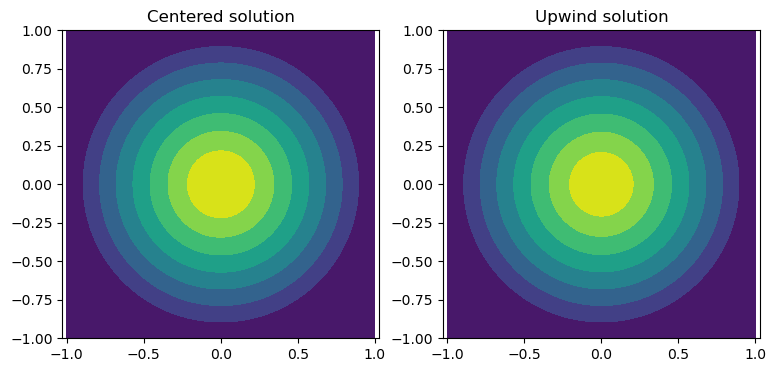

In [12]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1); plt.axis('equal'); plt.title('Centered solution')
plt.contourf(*X,solution_lf);
plt.subplot(1,2,2); plt.axis('equal'); plt.title('Upwind solution')
plt.contourf(*X,solution_upwind);

We introduce a drift term $\omega$. While $|\omega|<1$, the deterministic optimal control problem corresponding to $\|\nabla u - \omega\|=1$ remains locally controllable. The solution is smooth enough that the centered scheme remains monotone, and the two solutions agree.

In [13]:
drift_direction = np.array( (1,1) )/np.sqrt(2)

Centered discretization
Iteration: 1  Residue norm: 30.40805941478243
Iteration: 2  Residue norm: 7.379568316641786
Iteration: 3  Residue norm: 1.0964622384982343


Iteration: 4  Residue norm: 0.01800476146249519
Iteration: 5  Residue norm: 2.6812805282716567e-06
Iteration: 6  Residue norm: 6.505906924303417e-14
Target residue reached. Terminating.

Upwind discretization
Iteration: 1  Residue norm: 24.592819351648156
Iteration: 2  Residue norm: 5.778192346917685


Iteration: 3  Residue norm: 0.8418135077234823
Iteration: 4  Residue norm: 0.01753768523541277
Iteration: 5  Residue norm: 4.362129309321006e-06
Iteration: 6  Residue norm: 1.723066134218243e-13
Target residue reached. Terminating.


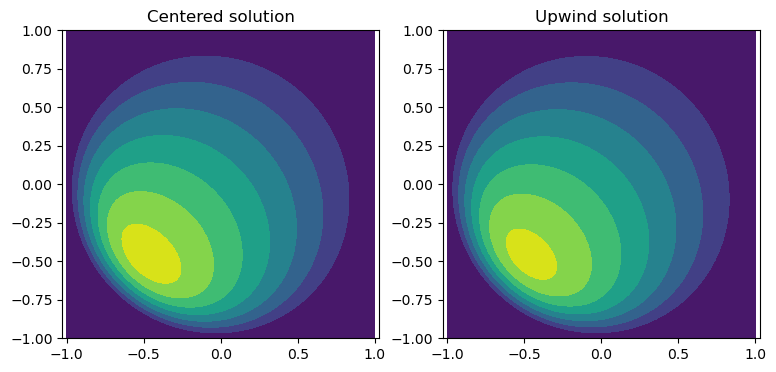

In [14]:
params1 = (A,0.8*drift_direction,D,1.,bc)
print("Centered discretization"); 
solution_lf = newton_root(SchemeCentered_Quad,guess,params1)
print()
print("Upwind discretization");   
solution_upwind = newton_root(SchemeUpwind,guess,params1)

plt.figure(figsize=(9,4))
plt.subplot(1,2,1); plt.axis('equal'); plt.title('Centered solution')
plt.contourf(*X,solution_lf);
plt.subplot(1,2,2); plt.axis('equal'); plt.title('Upwind solution')
plt.contourf(*X,solution_upwind);

On the other hand, if $|\omega|>1$, then the solution features a boundary layer, along which the gradient norm is large. As a result, the centered scheme looses monotonicity, and cannot the solver fails. 

Centered discretization
Iteration: 1  Residue norm: 50.265687232917536
Iteration: 2  Residue norm: 49336633.79105744
Iteration: 3  Residue norm: 12334165.482004056


Iteration: 4  Residue norm: 3083542.5588974967
Iteration: 5  Residue norm: 770880.4029508829
Iteration: 6  Residue norm: 177320707.80257964


Iteration: 8  Residue norm: 11082568.584614972
Iteration: 10  Residue norm: 692691.8418754636


Iteration: 12  Residue norm: 52619.874947132004
Max iterations exceeded. Aborting.

Upwind discretization
Iteration: 1  Residue norm: 26.15264872826889
Iteration: 2  Residue norm: 12.054212149921995
Iteration: 3  Residue norm: 0.015615302075318027
Iteration: 4  Residue norm: 1.0064768218853715e-06
Iteration: 5  Residue norm: 1.1501910535116622e-13
Target residue reached. Terminating.


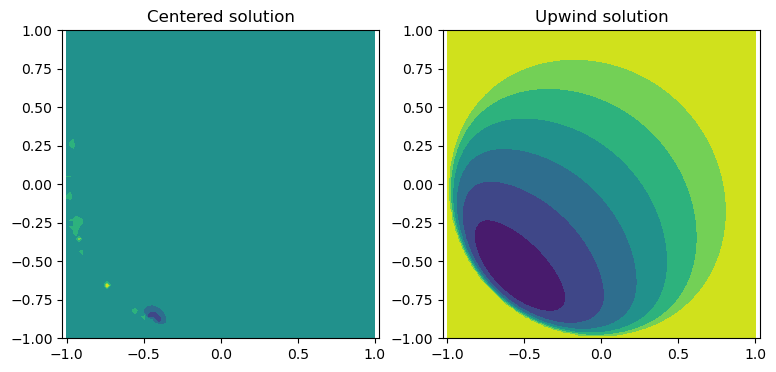

In [15]:
params2 = (A,1.2*drift_direction,D,1.,bc)
print("Centered discretization"); 
solution_lf = newton_root(SchemeCentered_Quad,guess,params2,
                          stop=stop(niter_max=12,raise_on_abort=False))
print()
print("Upwind discretization");   
solution_upwind = newton_root(SchemeUpwind,guess,params2)

plt.figure(figsize=(9,4))
plt.subplot(1,2,1); plt.axis('equal'); plt.title('Centered solution')
plt.contourf(*X,solution_lf);
plt.subplot(1,2,2); plt.axis('equal'); plt.title('Upwind solution')
plt.contourf(*X,solution_upwind);

The upwind scheme is monotone and solvable even for a vanishing diffusion tensor field $A$.

A numerical difficulty arises however for our Newton solver : the jacobian matrix $J$ of the scheme may not be invertible. Fortunately but $J+ \epsilon \mathrm{Id}$ is invertible for any $\epsilon>0$.

Iteration: 1  Residue norm: 39.513767346713
Iteration: 2  Residue norm: 9.840819177498114
Iteration: 3  Residue norm: 2.3997317508090434
Iteration: 4  Residue norm: 0.44412322609316157
Iteration: 5  Residue norm: 0.037963132835068025
Iteration: 6  Residue norm: 0.0008139125358357369
Iteration: 8  Residue norm: 7.2353676496828e-06
Iteration: 10  Residue norm: 9.558118230224011e-08
Iteration: 11  Residue norm: 9.553106306015025e-09
Target residue reached. Terminating.


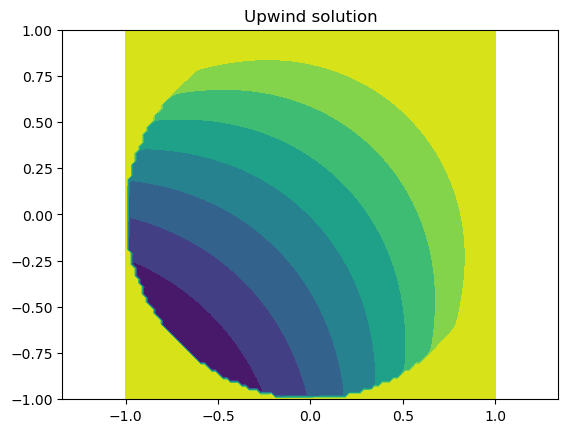

In [16]:
params = (None,1.2*drift_direction,D,1.,bc)
epsilon=1; relax = epsilon*ad.Sparse.identity(bc.shape)
solution_upwind = newton_root(SchemeUpwind,guess,params,relax=relax)


plt.axis('equal'); plt.title('Upwind solution')
plt.contourf(*X,solution_upwind);

For validation purposes, we reproduce the canonical example of a laplacian over a square domain.

Iteration: 1  Residue norm: 2.5011104298755527e-12
Target residue reached. Terminating.


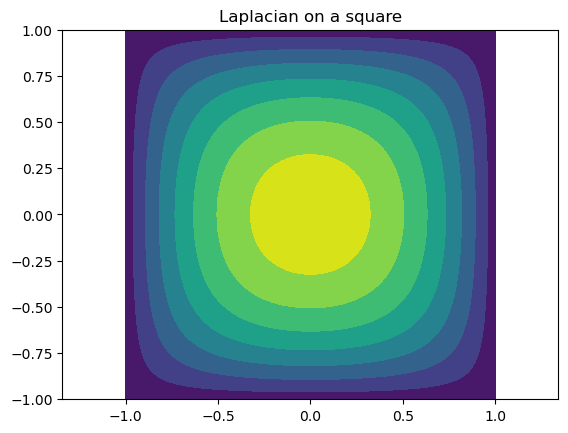

In [17]:
bc_square = Domain.MockDirichlet(bc.shape,bc.gridscale,0.)
params = (np.eye(2),np.zeros(2),None,1.,bc_square)
solution_upwind = newton_root(SchemeUpwind,guess,params)

plt.axis('equal'); plt.title('Laplacian on a square')
plt.contourf(*X,solution_upwind);

### 1.4 Alternative centered scheme

For completeness, we present a last scheme, that mixes the discretization principles of the previous two. In the considered examples, it behaves similarly to the first centered scheme. We use:
* Centered finite differences for second order accuracy,
* A sum-of-squares decomposition of the non-linearity, which is assumed to be quadratic.

In addition, the quadratic non-linearity must be defined in terms of a tensor $D(x)$ which is *proportionnal* to diffusion tensor $A(x)$. This is strong restriction, which possibly makes this scheme less useful in applications. This assumption could be weakened, but the the scheme would become more complex.

The resulting scheme is degenerate elliptic under the condition that
* $A(x)$ is positive definite at each point.
* $D(x)$ obeys a compatibility condition, satisfied in particular if $D(x)=\alpha(x) A(x)$ at each point.
* The grid scale $h>0$ is sufficiently small.
<!---* $D(x)$ is *proportionnal* to $A(x)$ at each point.--->


The approximation of the first order non-linearity reads
$$
    F(x,\nabla u(x)) =  \sum_{1 \leq i \leq n} \nu_i(x) \left(\frac{u(x+h e_i(x))-u(x-h e_i(x))}{2 h} - <\omega(x),e_i(x)>\right)^2+ O(h)
$$
where 
$$
    D(x) = \sum_{1 \leq i \leq n} \nu_i(x) e_i(x) e_i(x)^T
$$
is a tensor decomposition over the same stencil as $A(x)$, but with possibly negative weights $\nu_i(x)\in R$. This scheme is monotone provided the solution gradient is suitably bounded and 
$$
    \mu_i \geq h |\nu_i|,
$$
where $h$ is the discretization grid scale. This is in particular the case if $A(x) = \alpha(x) D(x)$ where $\alpha(x) \geq h$, at each point $x$.

<!---
*Note on the case where $A$ and $D$ are not proportionnal.* If $A$ and $D$ are not proportional, but both are positive definite, then one may rewrite the PDE as 
$$
    {-} \mathrm{tr}(\tilde A(x) \nabla^2 u(x)) -\alpha(x) \mathrm{Tr}(D(x) \nabla^2 u(x))  + \| \nabla u(x) -\omega(x)\|^2_{D(x)} - 1 = 0,
$$
where for instance 
$$
1/\alpha(x) := 2 \mathrm{tr} (D(x) A(x)^{-1}),
$$
which ensures that $\tilde A(x) := A(x)-\alpha(x) D(x)$ is positive definite, at each discretization point $x$. Monotony holds for the resulting scheme, provided $\alpha(x) \geq h$ and the solution gradient is suitably bounded.
--->

In [18]:
def SchemeCenteredAlt(u,A,omega,D,rhs,bc):
    # Compute the decompositions (here offset_e = offset_f)
    sb = Selling.ObtuseSuperbase(A) 
    mu,offset_e = Selling.Decomposition(A,sb=sb) # Non-negative decomposition
    nu,offset_f = Selling.Decomposition(D,sb=sb) # Decomposition with the same offsets
    omega_f = lp.dot_VA(omega,offset_f.astype(float))

    # Compute the first and second order finite differences
    du  = bc.DiffCentered(u,offset_f)
    d2u = bc.Diff2(u,offset_e)
    
    # Scheme in the interior
    mu,nu,omega_f = (bc.as_field(e) for e in (mu,nu,omega_f)) 
    residue = -lp.dot_VV(mu,d2u) + lp.dot_VV(nu, (du-omega_f)**2) - rhs

    # Boundary conditions
    return np.where(bc.interior,residue,u-bc.grid_values)

In [19]:
print()
print("No drift"); 
solution_no = newton_root(SchemeCenteredAlt,guess,params0)
print()
print("Weak drift"); 
solution_weak = newton_root(SchemeCenteredAlt,guess,params1)
print()
print("Non-controllable drift"); 
solution_strong = newton_root(SchemeCenteredAlt,guess,params2,
                                stop=stop(niter_max=12,raise_on_abort=False))


No drift
Iteration: 1  Residue norm: 24.999950894587233
Iteration: 2  Residue norm: 6.002480451567207
Iteration: 3  Residue norm: 1.2724251099266946
Iteration: 4  Residue norm: 0.16500802975014417


Iteration: 5  Residue norm: 0.004280708161434887


Iteration: 6  Residue norm: 2.2617146198111726e-06
Iteration: 7  Residue norm: 3.6060043839825084e-13
Target residue reached. Terminating.

Weak drift
Iteration: 1  Residue norm: 30.40805941478428
Iteration: 2  Residue norm: 7.379568316642263
Iteration: 3  Residue norm: 1.0964622384983578


Iteration: 4  Residue norm: 0.018004761462498076


Iteration: 5  Residue norm: 2.6812805289377906e-06
Iteration: 6  Residue norm: 6.505906924303417e-14
Target residue reached. Terminating.

Non-controllable drift
Iteration: 1  Residue norm: 50.26568723291751
Iteration: 2  Residue norm: 49336633.791056104
Iteration: 3  Residue norm: 12334165.482003726


Iteration: 4  Residue norm: 3083542.5588974156


Iteration: 5  Residue norm: 770880.4029508628
Iteration: 6  Residue norm: 177320707.80226308
Iteration: 8  Residue norm: 11082568.58459519
Iteration: 10  Residue norm: 692691.8418742283


Iteration: 12  Residue norm: 52619.87494355634
Max iterations exceeded. Aborting.


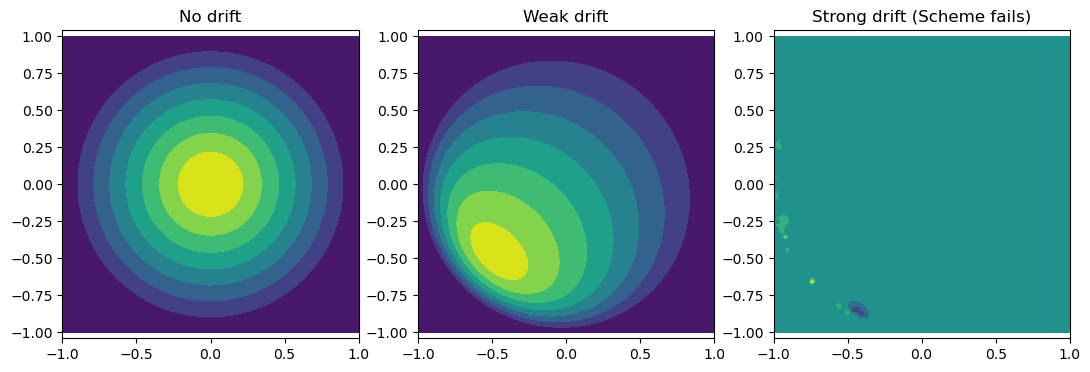

In [20]:
plt.figure(figsize=(13,4))
plt.subplot(1,3,1); plt.axis('equal'); plt.title('No drift')
plt.contourf(*X,solution_no);
plt.subplot(1,3,2); plt.axis('equal'); plt.title('Weak drift')
plt.contourf(*X,solution_weak);
plt.subplot(1,3,3); plt.axis('equal'); plt.title('Strong drift (Scheme fails)')
plt.contourf(*X,solution_strong);

## 2. Pure eikonal equations

The upwind scheme can accomodate, a null diffusion tensor $A$, so that the consider PDE degenerates to a first order eikonal-like equation. 
$$
    \|\nabla u-\omega\|_D^2-1=0.
$$
In that case we may in addition impose the boundary condition $+\infty$ on part of the domain boundary, in the sense of viscosity solutions. This corresponds to outflow boundary conditions.

**Note on the numerical solver.**
In this notebook, we use a Newton-like solver for all the PDEs. While this approach does eventually work for the considered examples, let us emphasize that it *lacks both speed and robustness in the case of pure eikonal equations*. Gauss-Siedel iterations (either sweeping or adaptive) are much more adequate, or even better the single pass fast marching method (applicable to this numerical scheme when $\omega=0$). 

**Stabilization of the linear solves**
The jacobian matrix $J$ of the considered numerical scheme is not invertible, but 
$$
    J + \epsilon_0 \mathrm{Id} - \epsilon_1 \Delta
$$
is invertible for any $\epsilon_0>0$ and $\epsilon_1\geq 0$, where $\Delta$ is the matrix of the laplacian operator.

We use both $\epsilon_0>0$ and $\epsilon_1>0$ in the first steps of Newton method, to propagate information over the domain using the laplacian kernel. Once a good approximation of the solution is obtained, we turn to a more basic relaxation with $\epsilon_0>0$ and $\epsilon_1=0$.

### 2.1 A Riemannian eikonal equation
We solve $\|\nabla u\|_D = 1$, where $D$ is the inverse to a Riemannian metric, which is specified in terms of its eigenvalues and eigenvectors.

In order to compute the Riemannian distance from the domain center $x_0$, we impose the Dirichlet boundary condition $u(x_0)=0$. On the domain boundary, we set $u=+\infty$ in the sense of viscosity solutions, to impose outflow boundary conditions.

In [21]:
# Generate the metric
eig1 = np.stack((np.full(bc.shape,1.),(np.pi/2)*np.cos(2*np.pi*X[0])))
eig1 /= scipy.linalg.norm(eig1,axis=0) 
eig2 = np.stack( (eig1[1],-eig1[0]) ) # Rotate eig1 by pi/2
lambda1, lambda2 = 0.8, 0.2
metric = lambda1**-2*lp.outer_self(eig1) + lambda2**-2*lp.outer_self(eig2)

# Boundary conditions set a seed in the center
bc_eikonal_grid_values = np.full(bc.shape,np.nan)
bc_eikonal_grid_values[bc.shape[0]//2,bc.shape[1]//2] = 1.

# Outflow boundary conditions on the square boundary obtained by padding +infinity
bc_eikonal = Domain.MockDirichlet(bc_eikonal_grid_values, bc.gridscale, padding=np.inf)

In [22]:
# Set the problem parameters
D_Riemann = lp.inverse(metric)
omega_Riemann = bc.as_field(np.zeros(2))

The following variables encode the identity and laplacian operators, devoted to the stabilization of the linear systems.

In [23]:
ident = ad.Sparse.identity(bc.shape)
lap   = bc_eikonal.Diff2(ident,(1,0)) + bc_eikonal.Diff2(ident,(0,1))
lap[0,:]=0.; lap[-1,:]=0.; lap[:,0]=0.; lap[:,-1]=0.; 

Iteration: 1  Residue norm: 1.0


Iteration: 5  Residue norm: 3.605432892874699


Iteration: 9  Residue norm: 194.58604911510207


Iteration: 13  Residue norm: 3.9728508145792913


Iteration: 17  Residue norm: 2.8803427436693863


Iteration: 20  Residue norm: 1.6378773781358142
Max iterations exceeded. Aborting.

Iteration: 1  Residue norm: 10.651492467554577
Iteration: 5  Residue norm: 0.34070548675785317
Iteration: 9  Residue norm: 0.026254530626949824


Iteration: 13  Residue norm: 0.0017178774713889622
Iteration: 17  Residue norm: 0.00010778223937157883
Iteration: 21  Residue norm: 6.7370720728821e-06


Iteration: 25  Residue norm: 4.210679548366514e-07
Iteration: 29  Residue norm: 2.631674766995218e-08
Iteration: 31  Residue norm: 6.5791907477574796e-09
Target residue reached. Terminating.


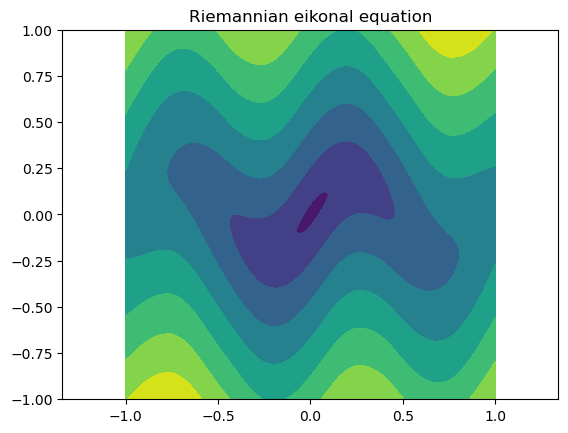

In [24]:
params = (None,omega_Riemann,D_Riemann,1.,bc_eikonal)

# First run 20 iterations with a strong relaxation, featuring a laplacian
solution_upwind = newton_root(SchemeUpwind,guess,params,relax=ident-bc_eikonal.gridscale*lap,
                             stop = stop(niter_max=20,raise_on_abort=False,niter_print=every4))

print()
# Then refine the solution, with a weaker relaxation
solution_upwind = newton_root(SchemeUpwind,solution_upwind,params,relax=ident,
                              stop = stop(niter_print=every4)) 

plt.axis('equal'); plt.title("Riemannian eikonal equation")
plt.contourf(*X,solution_upwind);

### 2.2 An eikonal equation of Rander type

We solve a classical instance of Zermelo's navigation problem: $u(x)=T$ is the smallest time for which there exists a path $\gamma : [0,T] \to \Omega$ such that 
$$
    \| \gamma'(t) - \eta(\gamma(t))\|_{M(\gamma(t))} \leq 1
$$
for all $0 \leq t \leq T$, and with the endpoint conditions $\gamma(0) = x_0$ (the seed point) and $\gamma(T)=x$.
Here $M$ is a prescribed Riemannian metric, and $\eta$ is a drift vector field. 

For well posedness, we require the problem to be locally controllable, which is the case provided 
$$
\| \eta(x)\|_{M(x)} < 1
$$
at all points of the domain.

In [25]:
# Choose the Riemannian metric and drift
metric = bc_eikonal.as_field( np.eye(2))
drift_max_speed = 0.8
drift = drift_max_speed*np.sin(2*np.pi*X[0])*np.sin(2*np.pi*X[1]) * X / ad.Optimization.norm(X,ord=2,axis=0)

In [26]:
def RanderDual(m,v):
    s = lp.inverse(m-lp.outer_self(v))
    w = lp.dot_AV(s,v)
    return (s*(1+lp.dot_VV(v,w)),w)

In [27]:
# Set the problem parameters
D_Rander,omega_Rander = RanderDual(lp.inverse(metric),drift)
D_Rander = lp.inverse(D_Rander)

Iteration: 1  Residue norm: 3.377923009093725


Iteration: 5  Residue norm: 782.3323881462628


Iteration: 9  Residue norm: 7.844631818162194


Iteration: 13  Residue norm: 0.7264236353476003


Iteration: 17  Residue norm: 0.2365958052116035
Iteration: 20  Residue norm: 0.09804071441839779
Max iterations exceeded. Aborting.



Iteration: 1  Residue norm: 0.011436478442580889
Iteration: 5  Residue norm: 0.0012592903006959366
Iteration: 9  Residue norm: 7.933843450369515e-05


Iteration: 13  Residue norm: 4.95868412153655e-06
Iteration: 17  Residue norm: 3.099181191679179e-07
Iteration: 21  Residue norm: 1.936986149253528e-08
Iteration: 22  Residue norm: 9.6849650521591e-09
Target residue reached. Terminating.


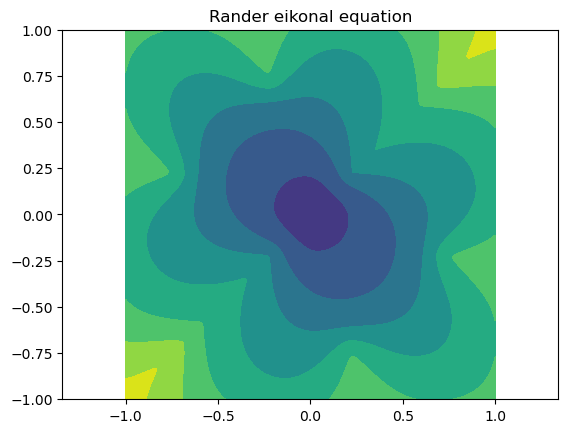

In [28]:
params = (None,omega_Rander,D_Rander,1.,bc_eikonal)
solution_upwind = newton_root(SchemeUpwind,guess,params, # Zero guess
                              relax=ident-bc_eikonal.gridscale*lap, # Laplacian in relaxation
                       stop=stop(niter_max=20,raise_on_abort=False,niter_print=every4) )

print()
solution_upwind = newton_root(SchemeUpwind,solution_upwind,params, # Previous solution as guess
                       relax=ident, stop=stop(niter_print=every4)) # Basic relaxation

plt.axis('equal'); plt.title("Rander eikonal equation")
plt.contourf(*X,solution_upwind);